# Example 5

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from datools.site_response_small import plot_damping_curve,plot_mrd_curve,cap_max_damping, view_layer, strength_correction,set_modulus_reduction
from IPython.display import Image, display
import copy




# Constructing and Adjusting a Soil Profile for Analysis in PyStrata

This example will show the options available to users when creating a soil profile for the pyStrata package. Focus will be given on how to manually adjust nonlinear soil property curves (e.g. shear modulus reduction and damping curves). A full outline of the example is provided below:

1. <b>Generate a soil profile</b><br>   
   <span style="margin-left: 30px;">→ Utilize different soil modulus reduction and damping curves (MRD):</  
   <span style="margin-left: 50px;">- Classify soil properties via Darendeli (2001) or other MRD model</span><br>   
   <span style="margin-left: 30px;">→ Cap soil damping to 15% (based on NRC recommendations)</span><br>      
   <span style="margin-left: 30px;">→ Scale laboratory D<sub>min</sub> to account for effects of wave scattering, etc.</span><br>   
   <span style="margin-left: 30px;">→ Apply strength correction techniques to accurately represent shear strengths mobilized at high strain levels.</span>   



# Step 1: Generate a Soil Profile

pyStrata allows the user several different methods in which to classify the damping (D) and shear modulus (G) properties of a soil at varying strains. For example, the user can select the Darendeli model (2001) and the Wang model (2022) to estimate soil damping.   
   
   Below, the soil profile for the Kik-Net site **KSRH09** will be analyzed.

## Darendeli (2001) Soil Profile

The characterize a Darendeli soil in pystrata, the following soil properties must be known (or assumed) for each layer in the relevant profile (Table 1):

<center>

**Table 1:** Darendeli (2001) Soil Property Input
| Soil Property         | Data Type  | Unit   | Default Value                      |
|-----------------------|------------|--------|------------------------------------|
| soil layer name       | str        | n/a    | optional                           |
| unit weight           | float      | kN/m³  | n/a                                |
| $\sigma_{mean}$       | float      | kN/m²  | 101.3                              |
| PI                    | float      | n/a    | 0                                  |
| OCR                   | float      | n/a    | 1                                  |
| excitation frequency  | float      | Hz     | 1                                  |
| number of cycles      | float      | n/a    | 10                                 |
| shear strain levels   | array_like | dec    | `np.logspace(-6, -1.5, num=20)`<br>(range: 1e-06 to 1e-1) |

</center>

The layer properties must also be defined in every single model. These include:

<center>

**Table 2:** Layer Property Input
| Soil Property         | Data Type  | Unit   | Default Value                      |
|-----------------------|------------|--------|------------------------------------|
| soil properties       | pyStrata SoilType        | n/a    | n/a                           |
| layer thickness       | float      | m | n/a                                |
| $V_s$                 | float      | m/s  | n/a                            |
| $D_{min}$             | float      | n/a    | `if None`, computes based on SoilType                                  |

</center>

An example pyStrata profile constructed using the Darendeli soil type:


In [29]:
import pystrata
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15, ocr=1,stress_mean=40), 6, 90),
        pystrata.site.Layer(pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15, ocr=1,stress_mean=94), 4, 220),
        pystrata.site.Layer(pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15, ocr=1,stress_mean=209), 30, 440),
        pystrata.site.Layer(pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15, ocr=1,stress_mean=420), 32, 460),
        pystrata.site.Layer(pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15, ocr=1,stress_mean=634), 31, 530),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 20.0, None, 0.01), 0, 530),
    ]
)



One can easily visualize the $V_s$ profile via:

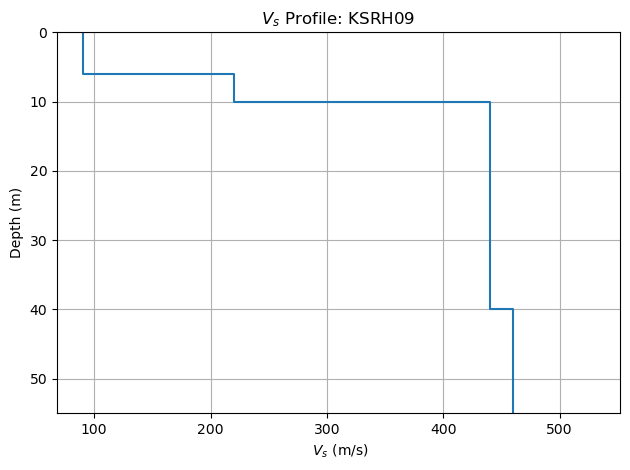

In [175]:

fig, ax = plt.subplots()

ax.plot(
    [layer.initial_shear_vel for layer in profile],
    [layer.depth for layer in profile],
    drawstyle="steps-pre",
)

ax.set(xlabel=" $V_s$ (m/s)", ylabel="Depth (m)", ylim=(55, 0),title='$V_s$ Profile: KSRH09')
ax.grid()
fig.tight_layout()

Or calculate $V_{s30}$ via:

In [176]:
vs_30 = profile.vs30()
print(f'Vs_30 for site KSRH09 is: {vs_30} m/s')

Vs_30 for site KSRH09 is: 230.23255813953486 m/s


## Adjusting $D_{min}$

Using a code in this package, it is straightforward to plot the modulus reduction and damping curves:

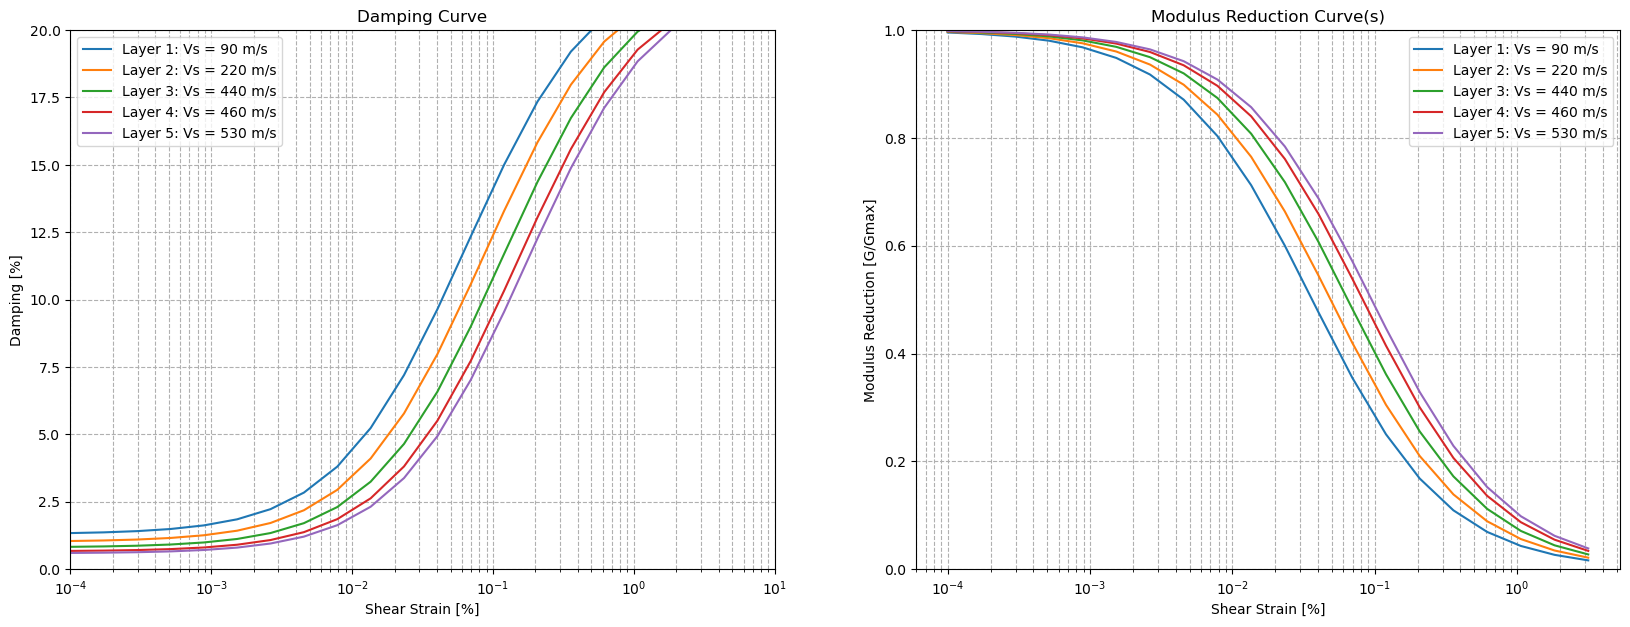

In [177]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plot_damping_curve(profile, ax=ax1)
plot_mrd_curve(profile, ax=ax2)

### Capping $D_{min}$

From above, the damping at high relative shear strains is unreasonable (i.e., not rooted in physical behaviour); therefore, it is necessary to cap the damping at 15%: 

Layer 1: Damping values capped at 15.0%.
Layer 2: Damping values capped at 15.0%.
Layer 3: Damping values capped at 15.0%.
Layer 4: Damping values capped at 15.0%.
Layer 5: Damping values capped at 15.0%.


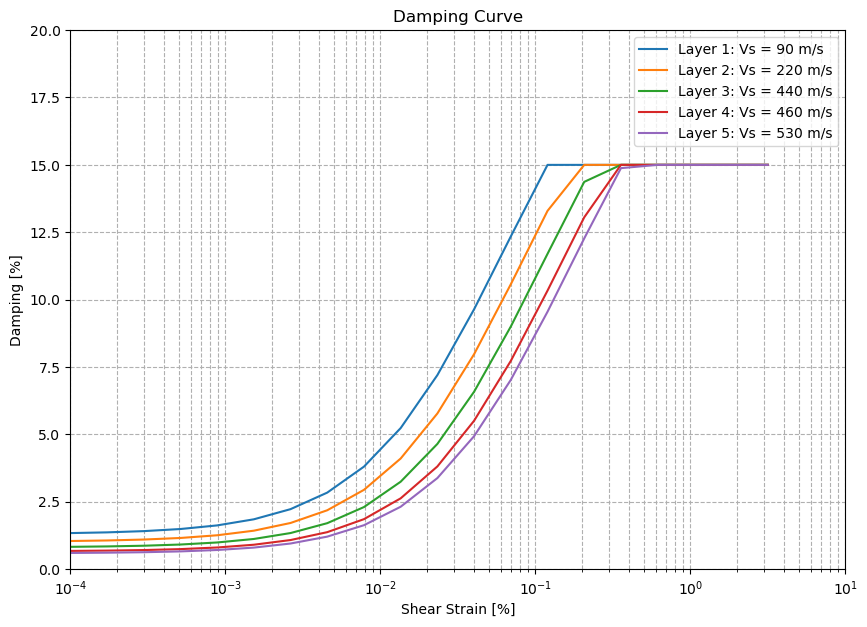

In [178]:
#function that caps all the damping values for each layer in constructed profile
profile = cap_max_damping(profile)
plot_damping_curve(profile)


### Adding a Scale Factor to $D_{min}$

In examples 3 and 4, $D_{min}$ scale factors were appled, with these scale factors derived to match surface ${\kappa}$ and ground motion parameters from a downhole array analysis (POINT TO examples that define Dmin scale factors)

 This scale factor is applied to the minimum damping of each soil layer. The scaled Dmin is combined with the hysteretic D from Daredenli to generate the full damping curve.  The Dmin scale factor to match the ${\kappa}$ for KSRH09 was found to be **10.14** in a previous analysis.

Layer 1: Damping values capped at 15.0%.
Layer 2: Damping values capped at 15.0%.
Layer 3: Damping values capped at 15.0%.
Layer 4: Damping values capped at 15.0%.
Layer 5: Damping values capped at 15.0%.


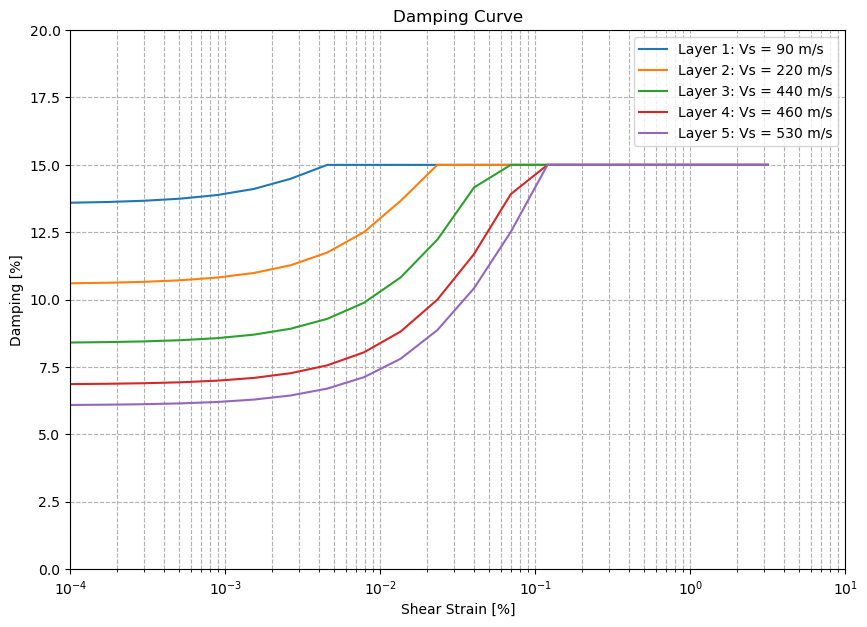

In [179]:
#### CHANGE KAPPA_SF TO DMIN_SF (DEFINE WHAT THIS IS)
kappa_sf = 10.14

# -------------------
# calculated the Dmin values generated from the Darendeli soil profile and multiply by scale factor
# -------------------
unscaled_dmin = [layer.damping_min for layer in profile.layers]

scaled_dmin = [dmin * kappa_sf for dmin in unscaled_dmin]

# -------------------
# Create new soil properties based off of scaled Dmin
# -------------------

soil_1 = pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15, 
                                         ocr=1,stress_mean=40,damping_min = scaled_dmin[0])

soil_2 = pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15,
                                          ocr=1,stress_mean=94, damping_min=scaled_dmin[1])
                   
soil_3 = pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15,
                                          ocr=1,stress_mean=209, damping_min = scaled_dmin[2]) 

soil_4 = pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15, ocr=1,
                                         stress_mean=420, damping_min =scaled_dmin[3])

soil_5 = pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15,
                                          ocr=1,stress_mean=634, damping_min = scaled_dmin[4])

soil_6 = pystrata.site.SoilType("Rock", 20.0, None, 0.1)

# -------------------
# Construct new pyStrata profile object
# -------------------

profile_adjusted = pystrata.site.Profile(
    [
        pystrata.site.Layer(soil_1, 6, 90),
        pystrata.site.Layer(soil_2, 4, 220),
        pystrata.site.Layer(soil_3, 30, 440),
        pystrata.site.Layer(soil_4, 32, 460),
        pystrata.site.Layer(soil_5, 31, 530),
        pystrata.site.Layer(soil_6, 0, 530),
    ]
)


# -------------------
# Plotting the Damping Curves for new Profile
# -------------------

profile_adjusted = cap_max_damping(profile_adjusted) #limiting damping to 15%
plot_damping_curve(profile_adjusted)


## Strength Correction

The veracity of site response analyses often necessitates strength correction [(Hashash et al., 2010)](https://scholarsmine.mst.edu/cgi/viewcontent.cgi?article=2952&context=icrageesd). 
   
This adjustment is more pertinent in cases with soft soils or large intensity input motions. When the shear stresses are mobilized closer to a soil's shear strengths, strength correction is especially warranted.   

The Darendeli model (2001) is based on laboratory tests that do not explicitly consider large shear strains; instead extrapolating to larger strains (~10+ %). In some cases, the extrapolated shear modulus (*G*) values are not reasonable. Therefore, strength correction is required.

### Estimating Soil Strengths

The shear stress at any given shear strain can be calculated via:

$$
\tau = G_{max} * (\frac{G}{G_{max}})_\gamma * \gamma
$$

The target shear stress ($\tau_{target}$) is the shear strength of the soil. There are two ways in which to calculate $\tau_{target}$:
1.  $c'$ - $\phi$'     (granular soils)
2.  $Su$               (fine-grain soils)

Mathematically:

$$
\tau_{target} = G_{max} * (\frac{G}{G_{max}})_\gamma * \gamma = \begin{cases}
c' + \sigma_v' tan(\phi'), & \text{(granular soils)} \\
S_u, & \text{(fine-grain soils)}
\end{cases}
$$

**Where** $\sigma_v'$ is the effective vertical stress at the midpoint of the layer.

Clearly, one must know the soil type prior to estimating its respective shear strength. For site KSRH09, it is necessary to return to the boring log:

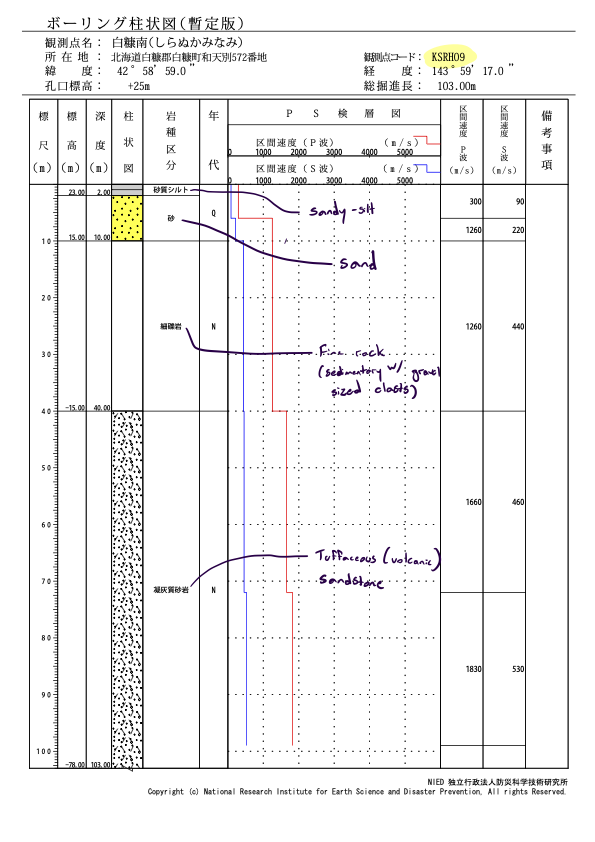

In [3]:
display(Image(filename='data/Example_5/KSRH09.png'))

Since both layers 1 and 2 are sands, it is necessary to estimate the friction angle. For example, an average unit weight and friction angle for sands are: **𝝓’ = 35° and 20.00 kN/m³**.

Meaning:

$$
\text{Layer 1}
$$
$$
\tau_{target} = 20(3) * tan(35°) = 42 kPa
$$
$$
\text{Layer 2}
$$
$$
\tau_{target} = (20(6) + (20-9.81)(2)) * tan(35°) = 98 kPa
$$


With the target strength identified, a function in this package can automatically run the strength correction process.

`strength_correction()`

What this function does it adjust the `a` value in the following equation after the reference strain ($\gamma_{R}$):

$$
\frac{G}{G_{\text{max}}} = \frac{1}{1 + \left( \frac{\gamma}{\gamma_R} \right)^a}
$$

This allows for a smooth stress-strain curve up until $\tau_{target}$.

An example for layers 1 and 2 are shown below:

In [7]:
strains, Gratio, tau, a2 = strength_correction(profile[0], 42)   #layer 1
strains_2, Gratio_2, tau_2, a2_2 = strength_correction(profile[1], 98)   #layer 2

Reference Strain [%]: 0.036317012543028056
Reference Strain [%]: 0.048904976263138195


Now, to replace the $\frac{G}{G_{max}}$ values in the pyStrata profile:

In [ ]:
profile_new = copy.deepcopy(profile)
set_modulus_reduction(profile_new[0],strains=strains,g_over_gmax=Gratio)
set_modulus_reduction(profile_new[1],strains=strains_2,g_over_gmax=Gratio_2)

And plotting the change:

Text(0.5, 1.0, 'New modulus-reduction curves')

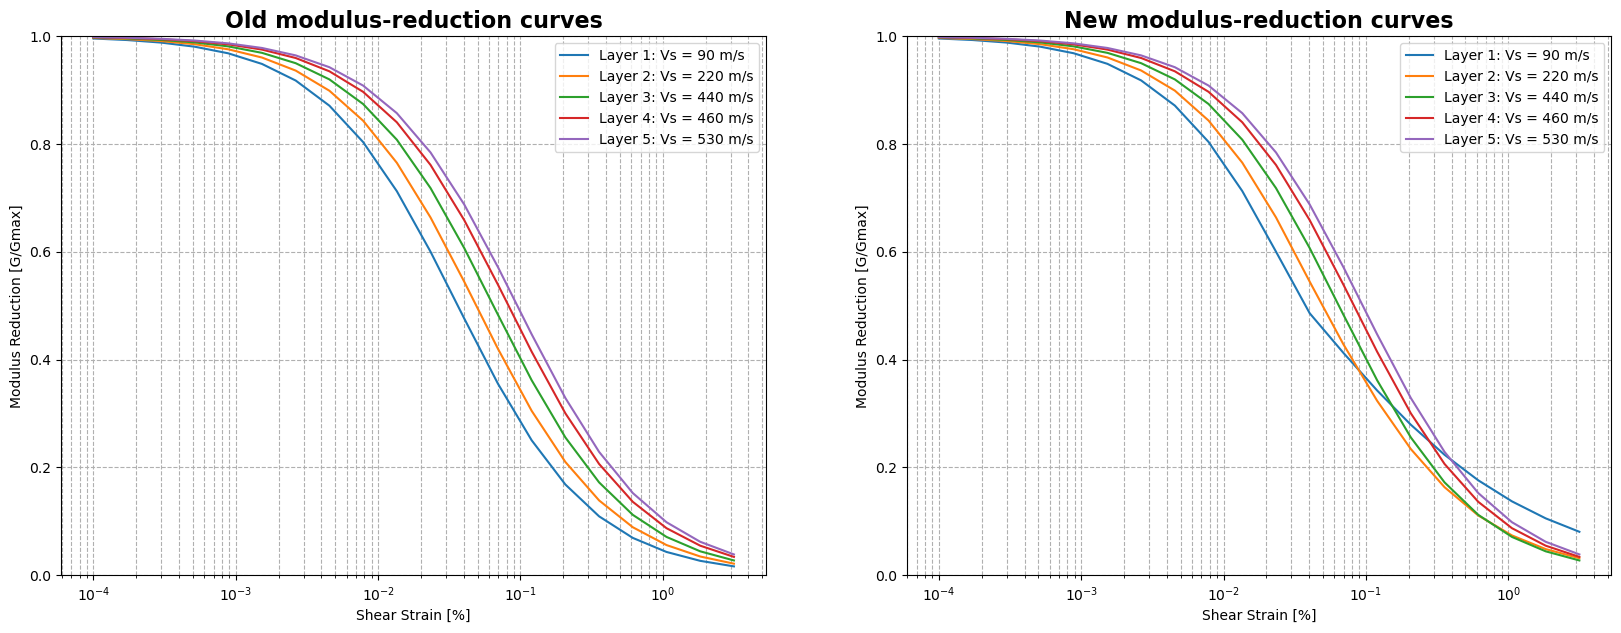

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
plot_mrd_curve(profile, ax=ax1)
plot_mrd_curve(profile_new, ax=ax2)
ax1.set_title("Old modulus-reduction curves",  fontsize=16, fontweight="bold")
ax2.set_title("New modulus-reduction curves",  fontsize=16, fontweight="bold")

And, to plot the new $\tau-\gamma$ curves post-strength correction:

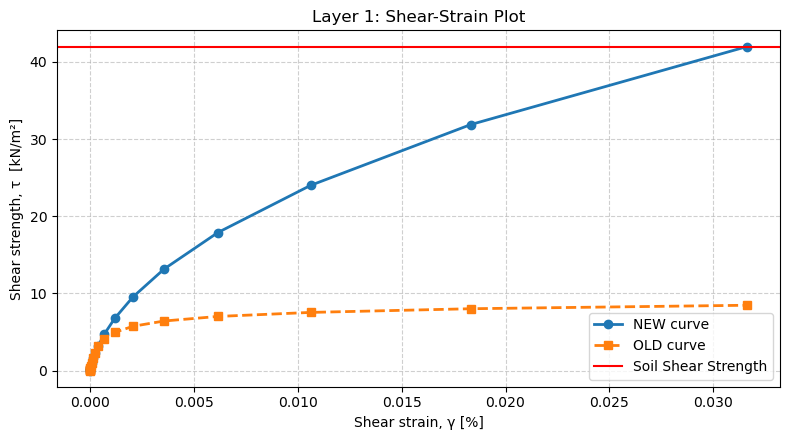

In [45]:

# ------------------------------------------------------------
# 1)  Reconstruct the ORIGINAL strength-degradation curve
# ------------------------------------------------------------

layer_old = profile[0]                
Gmax      = layer_old.initial_shear_mod #

strains_old = layer_old.soil_type.mod_reduc.strains
Gratio_old  = layer_old.soil_type.mod_reduc.values
tau_old     = Gmax * Gratio_old * strains_old   # τ = G · γ

# ------------------------------------------------------------
# 2)  Plot old vs. new on the same axes
# ------------------------------------------------------------
plt.figure(figsize=(8,4.5))

plt.plot(strains,tau, '-o',  label='NEW curve',  lw=2)

# OLD curve
plt.plot(strains_old,tau_old, '--s', label='OLD curve',  lw=2)

plt.axhline(y=42, label="Soil Shear Strength", color='red')

plt.xlabel('Shear strain, γ [%]')
plt.ylabel('Shear strength, τ  [kN/m²]')
plt.title('Layer 1: Shear-Strain Plot')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


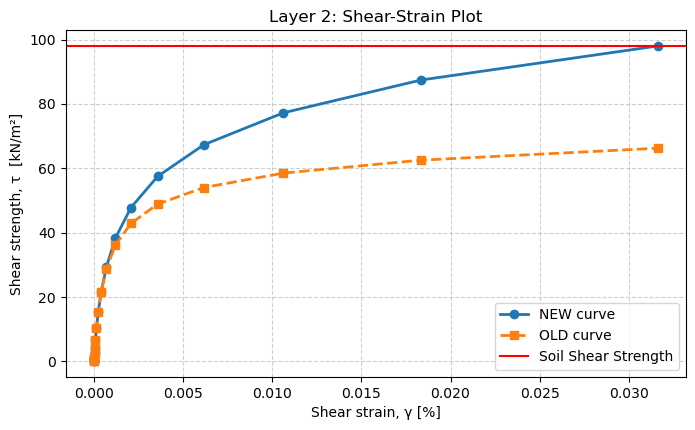

In [46]:

layer_old = profile[1]                
Gmax      = layer_old.initial_shear_mod #
strains_old = layer_old.soil_type.mod_reduc.strains
Gratio_old  = layer_old.soil_type.mod_reduc.values
tau_old     = Gmax * Gratio_old * strains_old   # τ = G · γ

plt.figure(figsize=(8,4.5))

plt.plot(strains_2,tau_2, '-o',  label='NEW curve',  lw=2)

plt.plot(strains_old,tau_old, '--s', label='OLD curve',  lw=2)

plt.axhline(y=98, label="Soil Shear Strength", color='red')

plt.xlabel('Shear strain, γ [%]')
plt.ylabel('Shear strength, τ  [kN/m²]')
plt.title('Layer 2: Shear-Strain Plot')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend()
plt.tight_layout
plt.show()

### Additional Notes

There is also a function in this package that allows one to easily see the properties in each soil layer in a pyStrata object: `view_layer()`.

In [ ]:
view_layer(profile[0]) #layer 1

Attribute            | Value
----------------------------------------
thickness            | 6.000 m
unit_weight          | 20.000 kN/m³
Vs (current)         | 90.000 m/s
Gmax (small-strain)  | 16519.403 kPa
σₘ                   | 40.000 kPa


Using the built in dataclass functionality of pyStrata Layer objects, it is also possible to generate arrays of the shear modulus and damping values:


In [49]:
view_layer(profile[0],show='modulus')

Attribute            | Value
----------------------------------------
thickness            | 6.000 m
unit_weight          | 20.000 kN/m³
Vs (current)         | 90.000 m/s
Gmax (small-strain)  | 16519.403 kPa
σₘ                   | 40.000 kPa

Modulus-reduction curve (γ → G/Gmax):
  1.00e-06 | 0.996
  1.73e-06 | 0.993
  2.98e-06 | 0.988
  5.13e-06 | 0.980
  8.86e-06 | 0.968
  1.53e-05 | 0.948
  2.64e-05 | 0.918
  4.55e-05 | 0.871
  7.85e-05 | 0.803
  1.35e-04 | 0.712
  2.34e-04 | 0.600
  4.03e-04 | 0.476
  6.95e-04 | 0.355
  1.20e-03 | 0.250
  2.07e-03 | 0.168
  3.57e-03 | 0.109
  6.16e-03 | 0.069
  1.06e-02 | 0.043
  1.83e-02 | 0.026
  3.16e-02 | 0.016


Moreover, one can even extrapolate the damping and shear modulus data over any given strain range. This allows the user to find the $\frac{G}{G_{max}}$ and $D$ values for any given strain:

In [ ]:
view_layer(profile[0], show="modulus", strains=[1e-4, 3e-3, 1e-2]) #Looking for the values at four discrete strains.

Attribute            | Value
----------------------------------------
thickness            | 6.000 m
unit_weight          | 20.000 kN/m³
Vs (current)         | 90.000 m/s
Gmax (small-strain)  | 16519.403 kPa
σₘ                   | 40.000 kPa

Modulus-reduction curve (γ → G/Gmax):
  1.00e-06 | 0.996
  1.73e-06 | 0.993
  2.98e-06 | 0.988
  5.13e-06 | 0.980
  8.86e-06 | 0.968
  1.53e-05 | 0.948
  2.64e-05 | 0.918
  4.55e-05 | 0.871
  7.85e-05 | 0.803
  1.35e-04 | 0.712
  2.34e-04 | 0.600
  4.03e-04 | 0.476
  6.95e-04 | 0.355
  1.20e-03 | 0.250
  2.07e-03 | 0.168
  3.57e-03 | 0.109
  6.16e-03 | 0.069
  1.06e-02 | 0.043
  1.83e-02 | 0.026
  3.16e-02 | 0.016

Selected strains (G/Gmax):
  1.00e-04 | 0.763
  3.00e-03 | 0.128
  1.00e-02 | 0.046
